In [1]:
# @title Installations
!pip install gradio gliner > /dev/null
!pip install accelerate -U > /dev/null
!pip install transformers huggingface_hub > /dev/null
!python -m pip install --upgrade pip==24.0 > /dev/null
!pip install evaluate fairseq seqeval pyngrok sacremoses > /dev/null

import gradio as gr
import re
import os
import json
import pandas as pd
from typing import *
import evaluate
import random
import shutil
import zipfile
import torch
from sklearn.metrics import confusion_matrix
from datasets import load_dataset, concatenate_datasets, DatasetDict
from gliner import GLiNER
from gliner import GLiNERConfig, GLiNER
from gliner.training import Trainer, TrainingArguments
from transformers import TrainerCallback
from gliner.data_processing.collator import DataCollatorWithPadding, DataCollator
from gliner.utils import load_config_as_namespace
from gliner.data_processing import WordsSplitter, GLiNERDataset

import warnings
from collections import defaultdict
from typing import Union, List, Literal

import numpy as np

if not os.path.exists("models"):
        os.makedirs("models")
if not os.path.exists("data"):
        os.makedirs("data")

AVAILABLE_MODELS = [
    "almanach/camembert-bio-gliner-v0.1",
    "knowledgator/gliner-multitask-large-v0.5",
    "urchade/gliner_multi-v2.1",
    "urchade/gliner_large_bio-v0.1",
    "numind/NuNER_Zero",
    "EmergentMethods/gliner_medium_news-v2.1",
]


DEPRECATION: omegaconf 2.0.6 has a non-standard dependency specifier PyYAML>=5.1.*. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of omegaconf or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [4]:
create_models_directory()

device = "cuda" if torch.cuda.is_available() else "cpu"

print("Loading model...")
model_name = "almanach/camembert-bio-gliner-v0.1"
model = GLiNER.from_pretrained(model_name).to(device)

print("Loading data...")
train_path = "/kaggle/working/data/QUAERO_train.json"
validation_path = "/kaggle/working/data/QUAERO_validation.json"

train_data = load_data(train_path)
validation_data = load_data(validation_path)

print(f"Training data size: {len(train_data)}, Testing data size: {len(validation_data)}")

train_dataset = GLiNERDataset(train_data, model.config, data_processor=model.data_processor)
test_dataset = GLiNERDataset(validation_data, model.config, data_processor=model.data_processor)
data_collator = DataCollatorWithPadding(model.config)

Loading model...


Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

Loading data...
Training data size: 886, Testing data size: 111


100%|██████████| 886/886 [00:00<00:00, 549889.52it/s]


Total number of entity classes:  10


100%|██████████| 111/111 [00:00<00:00, 299400.48it/s]

Total number of entity classes:  10


In [8]:
labels = []
for example in train_data:
    ner_data = example.get("ner", [])
    for entity in ner_data:
        label = entity[2]  
        if label not in labels:
            labels.append(label)

def evaluate_model(model, data, threshold=0.3, batch_size=16, labels=labels, display_metrics=False):
    results, f1 = model.evaluate(
        validation_data,
        flat_ner=True,
        threshold=threshold,
        batch_size=batch_size,
        entity_types=labels
    )
    
    results_str = results.strip()  
    metrics_parts = results_str.split("\t")  
    
    metrics = {}
    for part in metrics_parts:
        key, value = part.split(": ")  
        metrics[key] = float(value.replace("%", ""))  

    if display_metrics:
        print(f"=== Résultats de l'évaluation ===")
        print(f"Précision   : {metrics['P']:.2f}%")
        print(f"Rappel      : {metrics['R']:.2f}%")
        print(f"F1 Score    : {metrics['F1']:.2f}%")
    
    return metrics

In [6]:
def custom_evaluate(
    model,
    test_data,
    flat_ner=False,
    multi_label=False,
    threshold=0.5,
    batch_size=12,
    entity_types=None,
):
    model.eval()

    dataset = test_data
    collator = DataCollator(
        model.config,
        data_processor=model.data_processor,
        return_tokens=True,
        return_entities=True,
        return_id_to_classes=True,
        prepare_labels=False,
        entity_types=entity_types,
    )
    data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=False, collate_fn=collator
    )

    all_preds = []
    all_trues = []

    for batch in data_loader:
        for key in batch:
            if isinstance(batch[key], torch.Tensor):
                batch[key] = batch[key].to(model.device)

        model_output = model.model(**batch)[0]

        if not isinstance(model_output, torch.Tensor):
            model_output = torch.from_numpy(model_output)

        decoded_outputs = model.decoder.decode(
            batch["tokens"],
            batch["id_to_classes"],
            model_output,
            flat_ner=flat_ner,
            threshold=threshold,
            multi_label=multi_label,
        )
        all_preds.extend(decoded_outputs)
        all_trues.extend(batch["entities"])

    return all_preds, all_trues

In [10]:
all_preds, all_trues = custom_evaluate(
    model,
    validation_data,
    flat_ner=True,
    threshold=0.3,
    batch_size=12,
    entity_types=labels
)

In [11]:
def generate_confusion_matrix(all_preds, all_trues, output_dict=True):
    y_true = []
    y_pred = []
    
    for preds, trues in zip(all_preds, all_trues):
        true_entities = {(start, end): label for start, end, label in trues}
        pred_entities = {(start, end): label for start, end, label, score in preds}
        
        all_indices = set(true_entities.keys()).union(set(pred_entities.keys()))
        
        for index in all_indices:
            true_label = true_entities.get(index, "O")
            pred_label = pred_entities.get(index, "O")
            
            true_label = "Dehors" if true_label == "O" else true_label
            pred_label = "Dehors" if pred_label == "O" else pred_label
            
            y_true.append(true_label)
            y_pred.append(pred_label)
    
    labels = sorted(set(y_true + y_pred))
    if "Dehors" in labels:
        labels.remove("Dehors")
        labels = ["Dehors"] + labels
    
    labels_sans_dehors = [label for label in labels if label != "Dehors"]
    
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    report = classification_report(y_true, y_pred, labels=labels_sans_dehors, zero_division=0, output_dict=True)
    
    return cm, labels, report


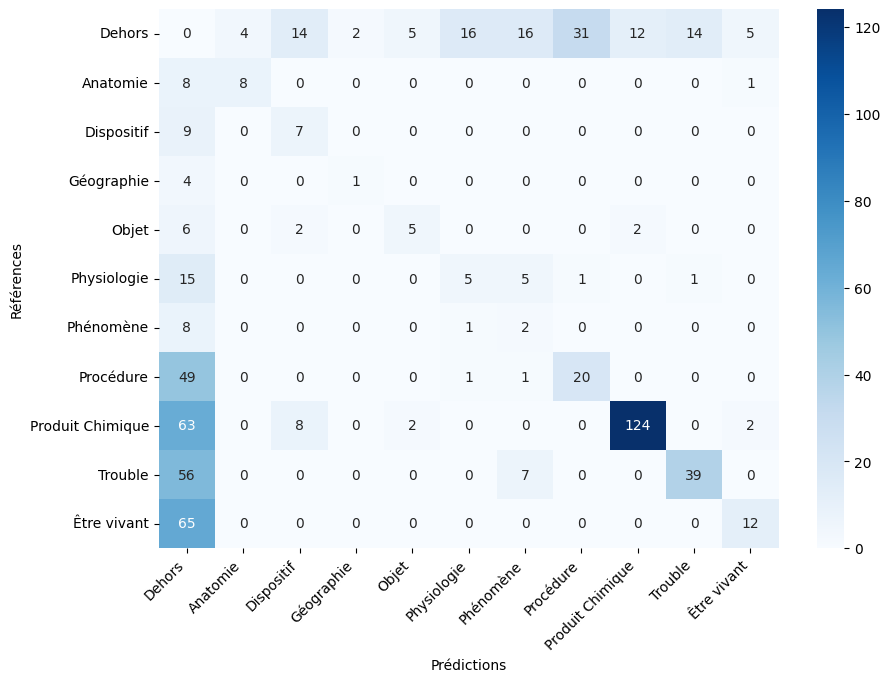

,precision,recall,f1-score,support
Anatomie,0.666667,0.470588,0.551724,17.0
Dispositif,0.225806,0.437500,0.297872,16.0
Géographie,0.333333,0.200000,0.250000,5.0
Objet,0.416667,0.333333,0.370370,15.0
Physiologie,0.217391,0.185185,0.200000,27.0
Phénomène,0.064516,0.181818,0.095238,11.0
Procédure,0.384615,0.281690,0.325203,71.0
Produit Chimique,0.898551,0.623116,0.735905,199.0
Trouble,0.722222,0.382353,0.500000,102.0
Être vivant,0.600000,0.155844,0.247423,77.0


In [12]:
# Résultats sans entrainement préalable, on remarque que GliNER est relativement bon de part sa nature few shot
# Ceci dit, après entrainement on reste à un Weighted F1 avoisinant les 70% comparé à 97% pour les autres modèles

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", 
                xticklabels=labels, yticklabels=labels, cmap="Blues")
    
    plt.xlabel("Prédictions")
    plt.xticks(rotation=45, ha="right")
    plt.ylabel("Références")
    plt.show()

cm, labels, report = generate_confusion_matrix(all_preds, all_trues, output_dict=True)

plot_confusion_matrix(cm, labels)
pd.DataFrame(report).transpose()